In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.linalg import norm
from matplotlib import ticker
from scipy.integrate import quad
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm, PowerNorm
from math import pi, sqrt, sin, cos, acos, atan2, exp, floor, hypot

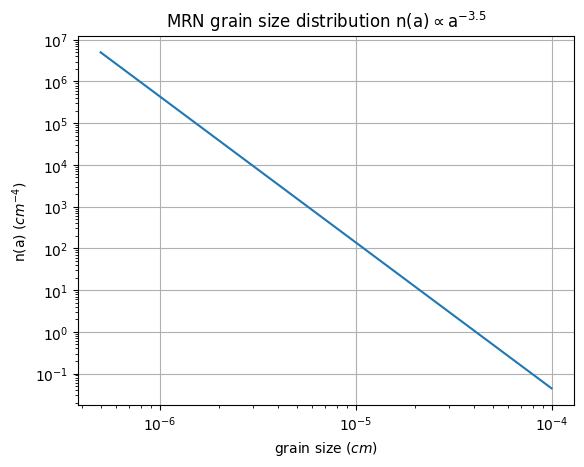

In [2]:
# default dust properties MRN
grain_size_min = 5e-7 # cm, minimum grain size
grain_size_max = 1e-4 # cm, maximum grain size
exponent = -3.5 # n(a) is proportional to a^-3.5
wavelength = 5.47e-5 # cm, F547M
rho_gr = 3 # grams / cm^3, Draine 2011 page 245, intermediate between graphite (2.24 g/cm^3) and olivine (3.8 g/cm^3)
sigma_rho_gr = 1.109

grain_sizes = np.logspace(np.log10(grain_size_min), np.log10(grain_size_max), 10000) # Preparing to Plot the Grain Size Distributions
normalization_constant = (exponent + 1) / (grain_size_max ** (exponent + 1) - grain_size_min ** (exponent + 1))
grains = np.where((grain_sizes >= grain_size_min) & (grain_sizes <= grain_size_max), normalization_constant * grain_sizes ** exponent, 0)

plt.plot(grain_sizes, grains)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('grain size ($cm$)')
plt.ylabel(r'n(a) ($cm^{-4}$)')
plt.title(r'MRN grain size distribution n(a)$\propto$a$^{-3.5}$')
plt.grid(True)

plt.show()

/var/folders/7n/v6gcxcpj68q6nnv2znnc85xc0000gn/T/ipykernel_2265/4140738629.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scattering_efficiency_integral = quad(lambda a: a ** (2 + exponent) * Q_sca_lambda(2 * pi * a / wavelength), grain_size_min, grain_size_max)[0] # integral after P in formual A8 of Li et al. 2024
/var/folders/7n/v6gcxcpj68q6nnv2znnc85xc0000gn/T/ipykernel_2265/4140738629.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to det

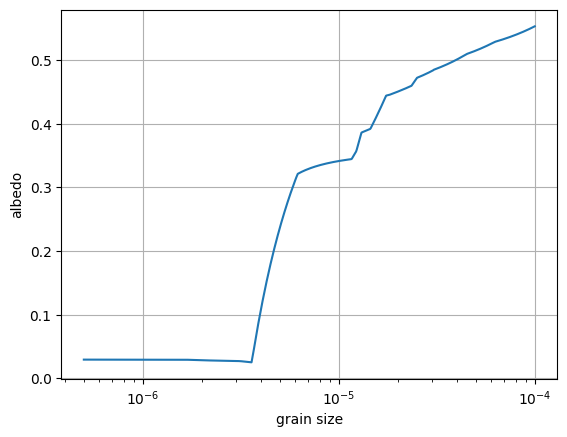

In [3]:
cross_section_constant = 3 * (exponent + 4) / (4 * rho_gr * (grain_size_max ** (exponent + 4) - grain_size_min ** (exponent + 4))) # constant before P in formual A8 and A9 of Li et al. 2024
load_Q_sca_lambda = np.vstack((np.array([[0, 0]]), np.asarray(np.loadtxt('scattering_efficiency.csv', delimiter = ',')).astype('float32'), np.array([[99999, 1]])))
load_Q_ext_lambda = np.vstack((np.array([[0, 0]]), np.asarray(np.loadtxt('extinction_efficiency.csv', delimiter = ',')).astype('float32'), np.array([[99999, 2]])))
Q_sca_lambda = interp1d(load_Q_sca_lambda[:, 0], load_Q_sca_lambda[:, 1], kind = 'linear') # Draine 2011 page 255, Figure 22.2
Q_ext_lambda = interp1d(load_Q_ext_lambda[:, 0], load_Q_ext_lambda[:, 1], kind = 'linear') # Draine 2011 page 255, Figure 22.3
scattering_efficiency_integral = quad(lambda a: a ** (2 + exponent) * Q_sca_lambda(2 * pi * a / wavelength), grain_size_min, grain_size_max)[0] # integral after P in formual A8 of Li et al. 2024
extinction_efficiency_integral = quad(lambda a: a ** (2 + exponent) * Q_ext_lambda(2 * pi * a / wavelength), grain_size_min, grain_size_max)[0] # integral after P in formual A9 of Li et al. 2024
sca_cm_squared_per_g = cross_section_constant * scattering_efficiency_integral # total scattering cross section cm^2 per g
ext_cm_squared_per_g = cross_section_constant * extinction_efficiency_integral

grain_sizes = np.linspace(grain_size_min, grain_size_max, 1000)

scattering_efficiency = Q_sca_lambda(2 * pi * grain_sizes / wavelength)
extinction_efficiency = Q_ext_lambda(2 * pi * grain_sizes / wavelength)

plt.plot(grain_sizes, scattering_efficiency / extinction_efficiency)

plt.xscale('log')

plt.xlabel('grain size')
plt.ylabel('albedo')
plt.grid(True)

plt.show() # albedo asymptote towards 0.6 as in Draine 2011 page 242, Figure 21.4

In [4]:
asymmetry_constant = 0.6 # Draine 2011 page 242, Figure 21.4

def henyey_greenstein(angle):
    return 1 / (4 * pi) * (1 - asymmetry_constant * asymmetry_constant) / ((1 + asymmetry_constant * asymmetry_constant - 2 * asymmetry_constant * cos(angle)) ** (3 / 2))

In [5]:
source_function = 0 # assume no dust emission in the optical

In [6]:
view_length = 1e16
view_size = view_length / 2
distance_steps = 200
theta_steps = 360
phi_steps = 360
distance_substeps = 10
dr = view_length / 2 / distance_steps
ds = dr / distance_substeps
dphi = pi / phi_steps

resolution = 201
depth = 201
depth_substeps = 10
dw = view_length / depth
ds_depth = dw / depth_substeps
grid_size = view_length / resolution

inclination_degrees = 60
inclination = pi * (inclination_degrees / 180)
sin_inc = sin(inclination)
cos_inc = cos(inclination)

In [7]:
def spherical_to_cartesian(r, theta, phi):
    sin_theta = sin(theta)
    x = r * sin_theta * cos(phi)
    y = r * sin_theta * sin(phi)
    z = r * cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = sqrt(x ** 2 + y ** 2 + z ** 2)
    if r == 0:
        return 0, 0, 0
    theta = acos(z / r)
    phi = atan2(y, x)
    return r, theta, phi

def cartesian_to_observer(x, y, z):
    u = x * cos_inc - z * sin_inc
    v = y
    w = x * sin_inc + z * cos_inc
    return u, v, w

def observer_to_cartesian(u, v, w):
    x = u * cos_inc + w * sin_inc
    y = v
    z = -u * sin_inc + w * cos_inc
    return x, y, z

def observer_to_pixels(u, v, w):
    px = int(floor((u + grid_size / 2) / grid_size) + ((resolution - 1) / 2))
    py = int(floor((v + grid_size / 2) / grid_size) + ((resolution - 1) / 2))
    d = int((view_length / 2 - w) / dw)
    return px, py, d

def pixels_to_observer(px, py, d):
    u = (px - ((resolution - 1) / 2)) * grid_size
    v = (py - ((resolution - 1) / 2)) * grid_size
    w = view_length / 2 - d * dw
    return u, v, w

def vector_angle(x1, y1, z1, x2, y2, z2):
    norm1 = hypot(x1, y1, z1)
    norm2 = hypot(x2, y2, z2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    dot = x1 * x2 + y1 * y2 + z1 * z2
    factor = dot / (norm1 * norm2)
    factor = max(-1, min(1, factor))
    return acos(factor)

In [8]:
def density_spherical(r, theta):
    if r <= 2e14 or r > 4e15:
        return 0
    return 10 / r ** 2

def density_cartesian(x, y, z):
    r, theta, _ = cartesian_to_spherical(x, y, z)
    return density_spherical(r, theta)

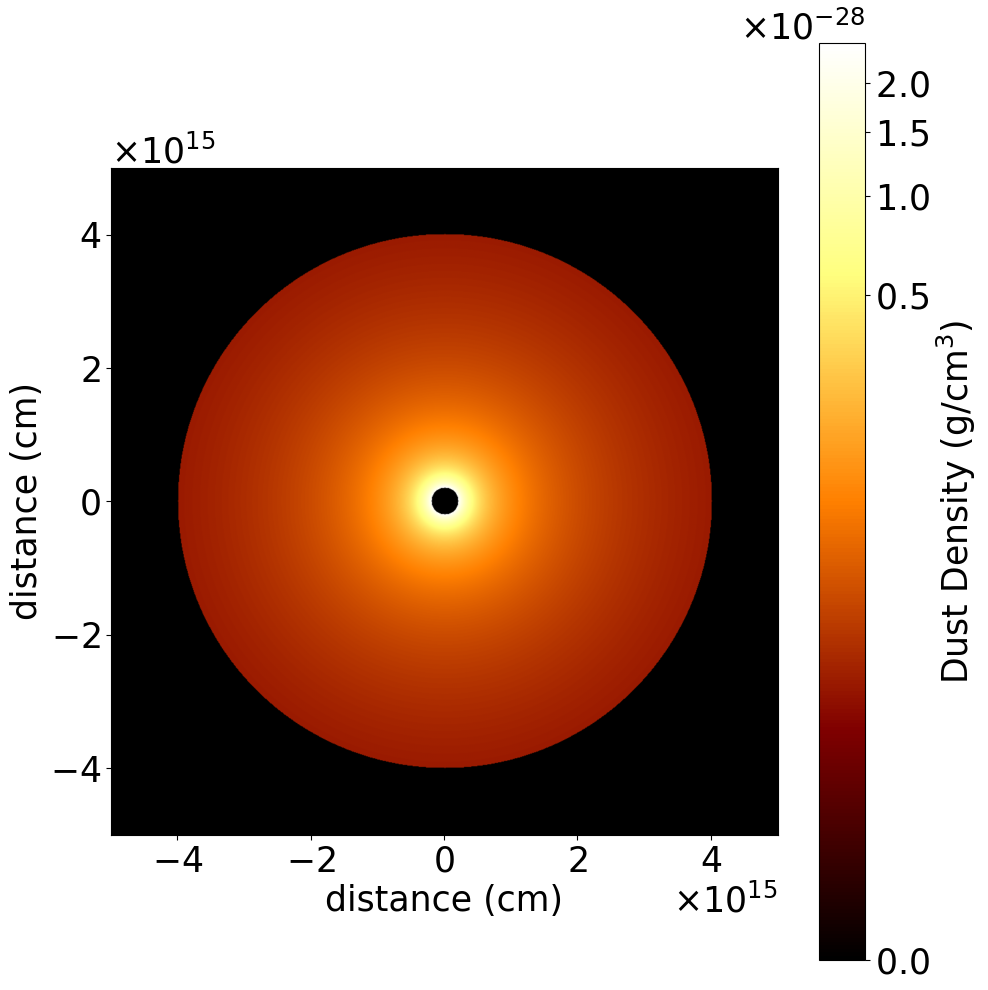

In [9]:
@np.vectorize
def density_map(x, y):
    return float(density_cartesian(0, y, -x))

density_grid = np.linspace(-view_size, view_size, 1001)
depth_grid = np.linspace(-view_size, view_size, 1001)
density_x, density_y = np.meshgrid(density_grid, density_grid)
density_value = density_map(density_x, density_y)
min_nonzero = np.min(density_value[density_value != 0])

fig, ax = plt.subplots(figsize = (10, 10))

im = ax.imshow(density_value, origin = 'lower', extent = [-view_size, view_size, -view_size, view_size], norm = PowerNorm(0.2), cmap = 'afmhot', interpolation = 'bilinear', aspect = 'equal')

ax.set_xlabel("distance (cm)", fontsize = 25)
ax.set_ylabel("distance (cm)", fontsize = 25)

formatter = ticker.ScalarFormatter(useMathText = True)
formatter.set_powerlimits((0,0))
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.get_offset_text().set_fontsize(25)
ax.yaxis.get_offset_text().set_fontsize(25)

cbar = fig.colorbar(im, ax = ax)
cbar.set_label('Dust Density (g/cm$^3$)', fontsize = 25)
cbar.ax.tick_params(labelsize = 25)
cbar_formatter = ticker.ScalarFormatter(useMathText = True)
cbar_formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_major_formatter(cbar_formatter)
cbar.ax.yaxis.get_offset_text().set_size(25)

ax.tick_params(axis = 'both', which = 'both', labelsize = 25)
plt.tight_layout()

plt.show()

In [10]:
def propagate_center_to_first(I, r, theta):

    for i in range(distance_substeps):
    
        k_v = (ext_cm_squared_per_g + sca_cm_squared_per_g) * density_spherical(r + i * ds, theta) # attenuation coefficient, units: cm^-1
        j_v = source_function * k_v

        dI = -I * k_v * ds + j_v * ds
        I = I + dI
    
    return I

def compute_one_angle(i):
    row = np.ones(distance_steps + 1)
    theta = acos(1 - (i + 1) / theta_steps) # all photons between (theta - dtheta) to theta are sent to the angle theta except for theta = dtheta. 
    
    for j in range(1, distance_steps + 1):
        r = j * dr
        row[j] = propagate_center_to_first(row[j - 1], r, theta)

    return row * sin(theta) # In later code, photons sent toward uniform theta. There are denser photons sent near the axes. We penalize them here

def compute_spherical():
    results = Parallel(n_jobs = -1)(
        delayed(compute_one_angle)(i) 
        for i in range(theta_steps)
    )
    return np.array(results)

spherical_array = compute_spherical()

In [11]:
cubical_array = np.zeros((resolution, (resolution + 1) // 2, depth))
image_array = np.zeros((resolution, (resolution + 1) // 2, depth))

def send_photon(i, j, phi):

    r = j * dr
    theta = acos(1 - (i + 1) / theta_steps)

    intensity = spherical_array[i, j]

    x, y, z = spherical_to_cartesian(r, theta, phi)
    u, v, w = cartesian_to_observer(x, y, z)
    px, py, d = observer_to_pixels(u, v, w)

    scattering_angle = vector_angle(u, v, w, 0, 0, 1)

    if px >= 0 and px < resolution and py >= 0 and py <= (resolution + 1) // 2:
        increment = intensity * (1 - exp(-dr * sca_cm_squared_per_g * density_spherical(r, theta))) # now that the photon arrived, calculate the chance to scatter between r + dr
        cubical_array[px, py, d] += increment # reserved for further scattering
        image_array[px, py, d] += increment * henyey_greenstein(scattering_angle) # peel-off amount

    if i == theta_steps:
        return # if theta is pi / 2, don't need to send mirror photon

    x, y, z = spherical_to_cartesian(r, pi - theta, phi)
    u, v, w = cartesian_to_observer(x, y, z)
    px, py, d = observer_to_pixels(u, v, w)

    scattering_angle = vector_angle(u, v, w, 0, 0, 1)

    if px >= 0 and px < resolution and py >= 0 and py <= (resolution + 1) // 2:
        increment = intensity * (1 - exp(-dr * sca_cm_squared_per_g * density_spherical(r, theta)))
        cubical_array[px, py, d] += increment
        image_array[px, py, d] += increment * henyey_greenstein(scattering_angle)

for i in tqdm(range(theta_steps)):
    for j in range(1, distance_steps + 1):
        for phi in np.arange(-pi + dphi / 2, dphi / 2, dphi): # avoid phi = 0 or pi, no complications when we mirror
            send_photon(i, j, phi)

image_array[:, -1, :] *= 2
cubical_array[:, -1, :] *= 2 # for the center row, we only calculated the top half, therefore we need to compensate
image_array[(resolution - 1) // 2, (resolution - 1) // 2, (depth - 1) // 2] += theta_steps * distance_steps * phi_steps * 2

100%|█████████████████████████████████████████| 360/360 [01:05<00:00,  5.51it/s]


In [12]:
def propagate_any(I, x0, y0, z0, random_x, random_y, random_z, random_steps):

    x, y, z = x0, y0, z0
    
    for i in range(random_steps):

        x += random_x * ds_depth
        y += random_y * ds_depth
        z += random_z * ds_depth

        if x ** 2 + y ** 2 + z ** 2 >= view_length ** 2:
            return 0, 0, 0, 0 # photon escapes
    
        k_v = (ext_cm_squared_per_g + sca_cm_squared_per_g) * density_cartesian(x, y, z) # attenuation coefficient, units: cm^-1
        j_v = source_function * k_v

        dI = -I * k_v * ds_depth + j_v * ds_depth
        I = I + dI
    
    return x, y, z, I

def multiple_scattering(weight, px, py, d):

    u, v, w = pixels_to_observer(px, py, d)
    x0, y0, z0 = observer_to_cartesian(u, v, w)
    
    while True:

        random_phi = 2 * pi * np.random.rand()
        random_z = 2 * np.random.rand() - 1
        random_r = sqrt(1 - random_z ** 2)
        random_x = random_r * cos(random_phi)
        random_y = random_r * sin(random_phi)

        random_steps = int(np.random.randint(depth * depth_substeps) + 1)

        I = cubical_array[px, py, d]
        scattering_angle = vector_angle(x0, y0, z0, random_x, random_y, random_z)
        I = I * henyey_greenstein(scattering_angle)

        x_dest, y_dest, z_dest, I_dest = propagate_any(I, x0, y0, z0, random_x, random_y, random_z, random_steps)

        if I_dest == 0:
            break

        u_dest, v_dest, w_dest = cartesian_to_observer(x_dest, y_dest, z_dest)
        px_dest, py_dest, d_dest = observer_to_pixels(u_dest, v_dest, w_dest)

        if px_dest >= 0 and px_dest < resolution and py_dest >= 0 and py_dest < (resolution + 1) // 2 and d_dest >= 0 and d_dest < depth:

            peel_off_angle = vector_angle(random_x, random_y, random_z, 0, 0, 1)
            image_array[px_dest, py_dest, d_dest] += weight * I_dest * (1 - exp(-ds_depth * sca_cm_squared_per_g * density_cartesian(x_dest, y_dest, z_dest))) * henyey_greenstein(peel_off_angle)
        
        else:
            break

all_positions = [
    (px, py, d)
    for px in range(resolution)
    for py in range((resolution + 1) // 2)
    for d in range(depth)
]

ms_count = 100
ms_weight = resolution * ((resolution + 1) // 2) * depth / ms_count

sampled_positions = random.sample(all_positions, 100)

for px, py, d in tqdm(sampled_positions):
    multiple_scattering(ms_weight, px, py, d)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1920.09it/s]


In [13]:
def propagate_los(I, px, py, d):

    u, v, w = pixels_to_observer(px, py, d)
    
    for i in range(depth_substeps):
        
        x, y, z = observer_to_cartesian(u, v, w - i * ds_depth)
    
        k_v = (ext_cm_squared_per_g + sca_cm_squared_per_g) * density_cartesian(x, y, z) # attenuation coefficient, units: cm^-1
        j_v = source_function * k_v

        dI = -I * k_v * ds_depth + j_v * ds_depth
        I = I + dI
    
    return I

for px in tqdm(range(resolution)):
    for py in range((resolution + 1) // 2):
        for d in reversed(range(depth - 1)):
            image_array[px, py, d] += propagate_los(image_array[px, py, d + 1], px, py, d)

100%|█████████████████████████████████████████| 201/201 [00:18<00:00, 10.83it/s]


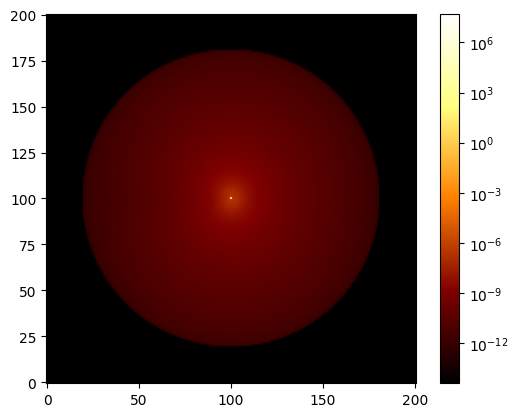

Exception ignored in: <function ResourceTracker.__del__ at 0x11815d3a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104ee93a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

In [14]:
image = np.vstack((np.transpose(image_array[:, :, 0], (1, 0)), np.transpose(image_array[:, :, 0], (1, 0))[:-1, :][::-1, :]))

buffer = np.min(image[image > 0])
buffered_image = image.copy()
buffered_image[buffered_image <= buffer] = buffer

plt.imshow(buffered_image, origin = 'lower', cmap = 'afmhot', norm = LogNorm())
plt.colorbar()
plt.show()